# US


data from https://github.com/CSSEGISandData/COVID-19

or

https://www.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

In [2]:
import datetime

In [3]:
now  = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

In [4]:
print(datetime.datetime.now())
print(now)

2020-05-20 20:23:40.942410
20200520_202340


In [5]:
xl_writer = pd.ExcelWriter(f"covid19_USA_data_{now}.xlsx")

In [6]:
url_cases = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv?_sm_au_=iVVZQ0fSPs48H6VNRMpVsKQtC6Vvq"

In [7]:
url_deaths = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv"

In [8]:
def crt_data(url, xl_writer, name):
    df = pd.read_csv(url)
    df.to_excel(xl_writer, name)
    if "Population" in df.columns:
        columns_to_del = ["UID", "iso2", "code3", "iso3", "FIPS", "Admin2", "Country_Region", "Lat", "Long_", "Combined_Key", "Population"]
    else:
        columns_to_del = ["UID", "iso2", "code3", "iso3", "FIPS", "Admin2", "Country_Region", "Lat", "Long_", "Combined_Key"]
    df2 = df[(df["iso2"] == "US") & (~df["Admin2"].isna())].drop(columns=columns_to_del)
    df4 = pd.DataFrame(df2.groupby(by=["Province_State",]).sum().T.to_records()).rename(columns={'index': 'date'})
    df4["date"] = pd.to_datetime(df4["date"])
    df4["day_of_year"] = df4["date"].dt.dayofyear
    return df4.set_index(['date', 'day_of_year'])

In [9]:
cases = crt_data(url_cases, xl_writer, "Cases Raw")

In [10]:
cases.to_excel(xl_writer, "Cases")

In [11]:
cases_summary = cases.max()

In [12]:
cases_summary.sort_values(ascending=False, inplace=True)

In [13]:
cases_summary.to_excel(xl_writer, "Cases Summary")

In [14]:
deaths = crt_data(url_deaths, xl_writer, "Deaths Raw")

In [15]:
deaths.to_excel(xl_writer, "Deaths")

In [16]:
deaths_summary = deaths.max()

In [17]:
xl_writer.close()

In [18]:
def plot_data(dataframe, logx=False, logy=False, **kwargs):
    if logx:
        df = dataframe.reset_index(level=0, drop=True)
        return df.plot(logx=logx, logy=logy, **kwargs)
    else:
        df = dataframe.reset_index(level=1, drop=True)
        return df.plot(logy=logy, **kwargs) 

In [19]:
def plot_state(cases, deaths, state="California", exp=False):
    fig, ((ax11, ax12), (ax21, ax22)) = plt.subplots(2, 2, figsize=(16, 13))
    if isinstance(state, (list, tuple)):
        pass
    else:
        fig.suptitle(state)
    #
    plot11 = plot_data(cases[state], ax=ax11)
    plot21 = plot_data(deaths[state], ax=ax21)
    if exp:
        plot12 = plot_data(cases[state], logy=True, logx=False, ax=ax12)
        plot22 = plot_data(deaths[state], logy=True, logx=False, ax=ax22)
    else:
        plot22 = plot_data(cases[state], logy=True, logx=False, ax=ax12)
        plot22 = plot_data(deaths[state], logy=True, logx=False, ax=ax22)
    

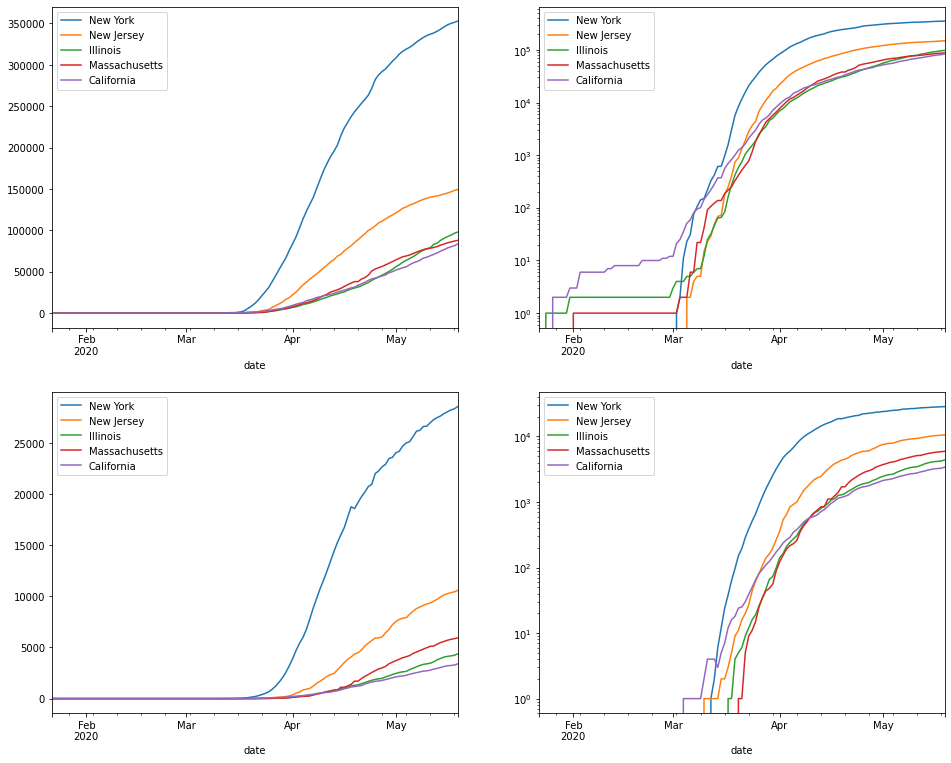

In [21]:
plot_state(cases, deaths, state=list(cases_summary.index[:5]))

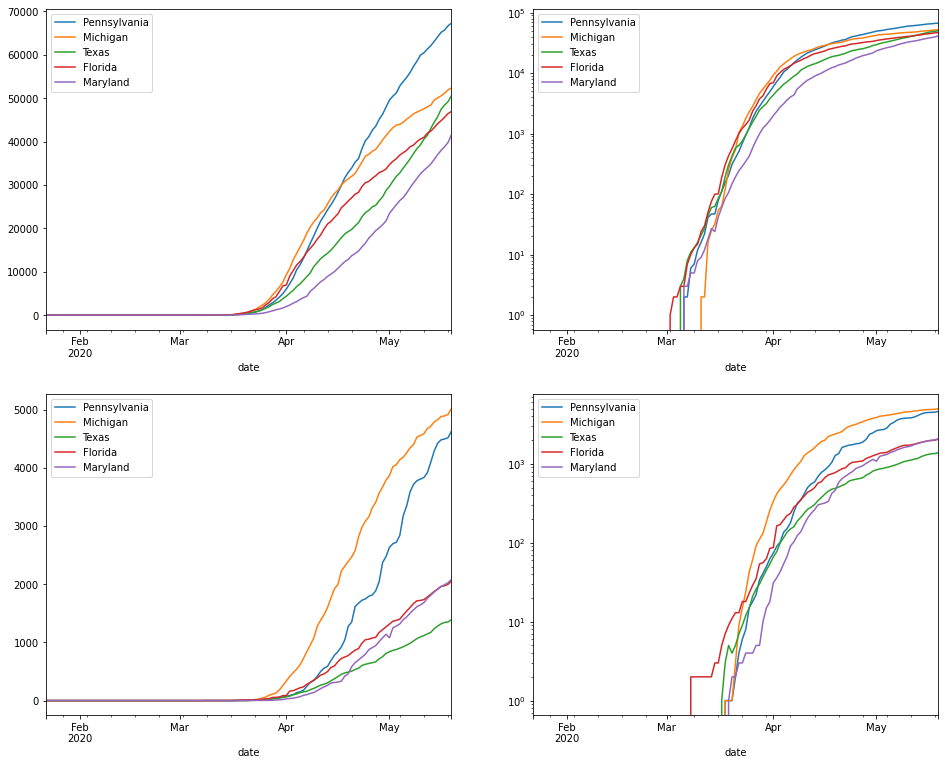

In [22]:
plot_state(cases, deaths, state=list(cases_summary.index[5:10]))

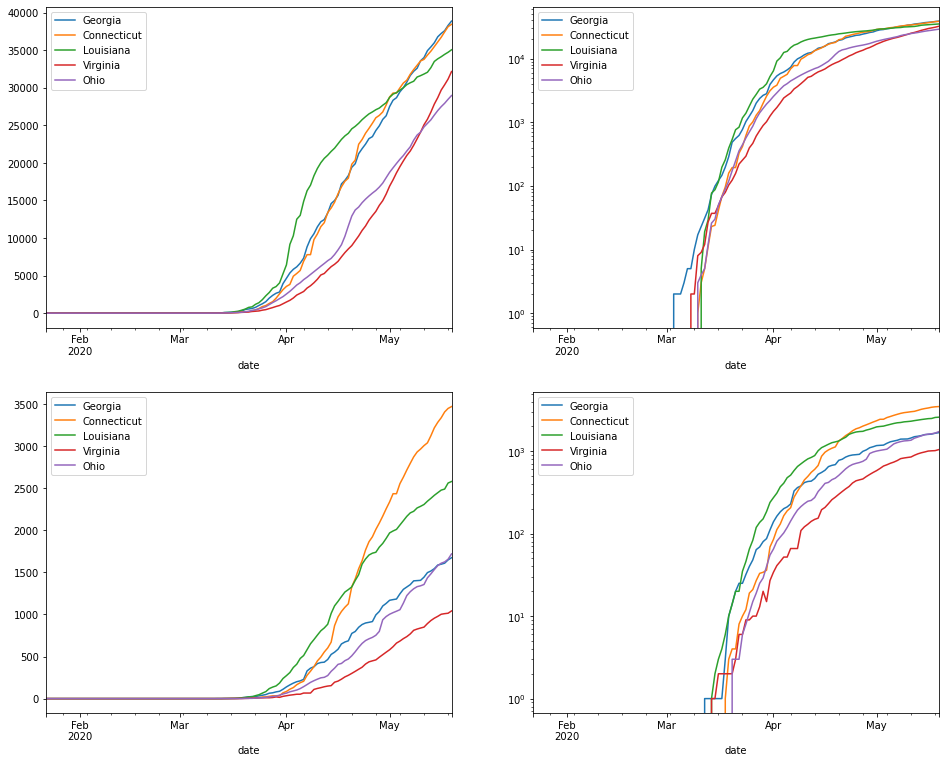

In [23]:
plot_state(cases, deaths, state=list(cases_summary.index[10:15]))

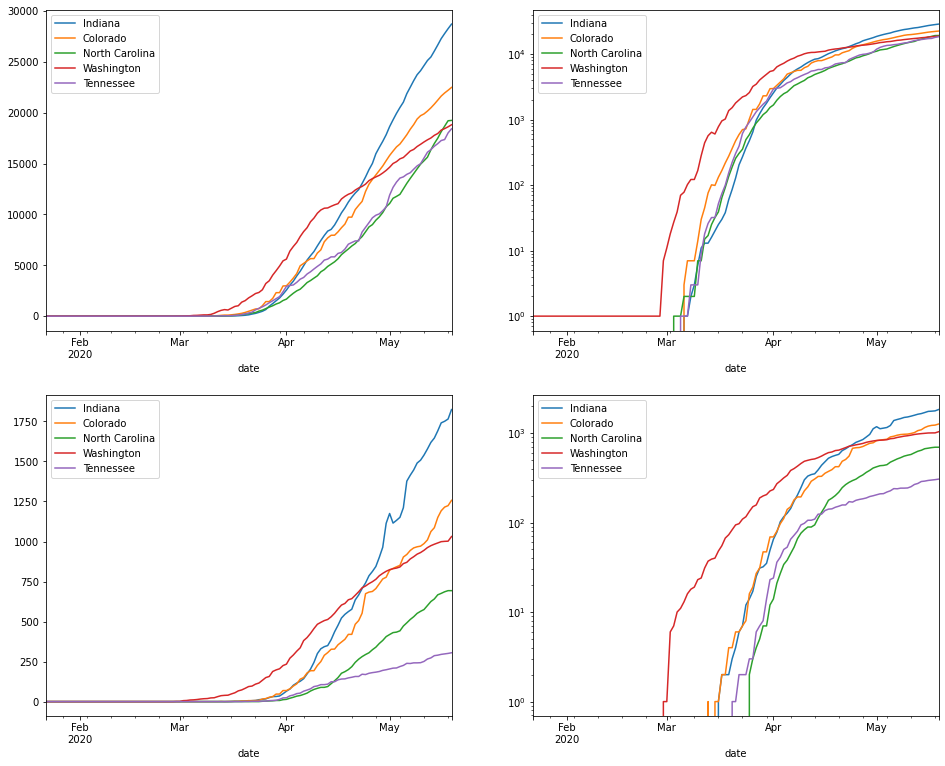

In [24]:
plot_state(cases, deaths,  state=list(cases_summary.index[15:20]))

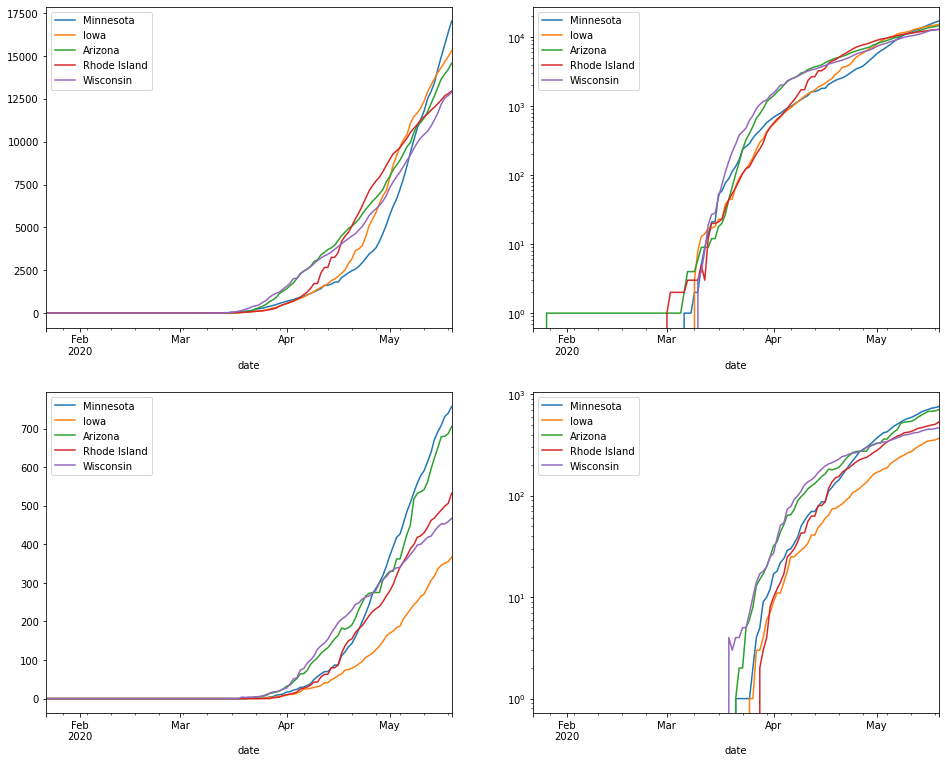

In [25]:
plot_state(cases, deaths, state=list(cases_summary.index[20:25]))

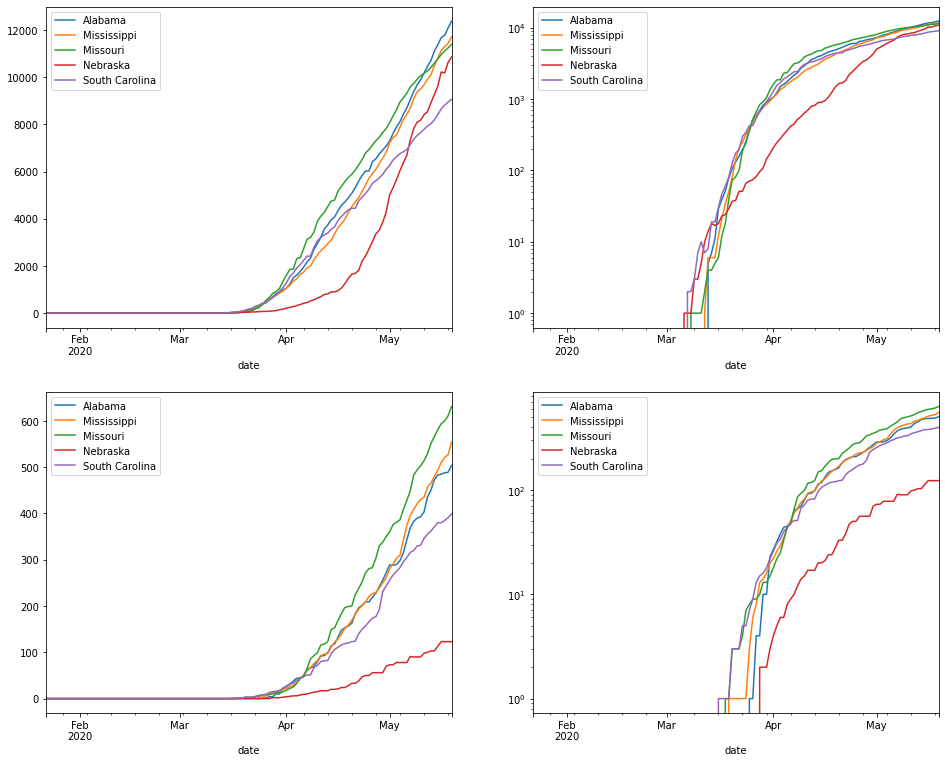

In [26]:
plot_state(cases, deaths, state=list(cases_summary.index[25:30]))

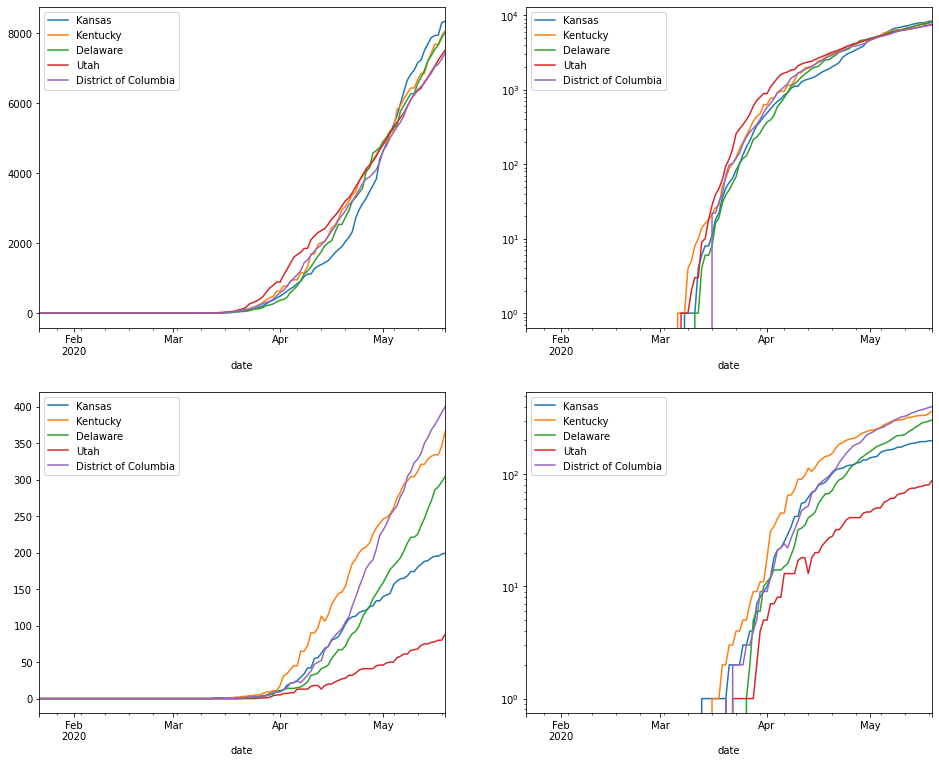

In [27]:
plot_state(cases, deaths, state=list(cases_summary.index[30:35]))

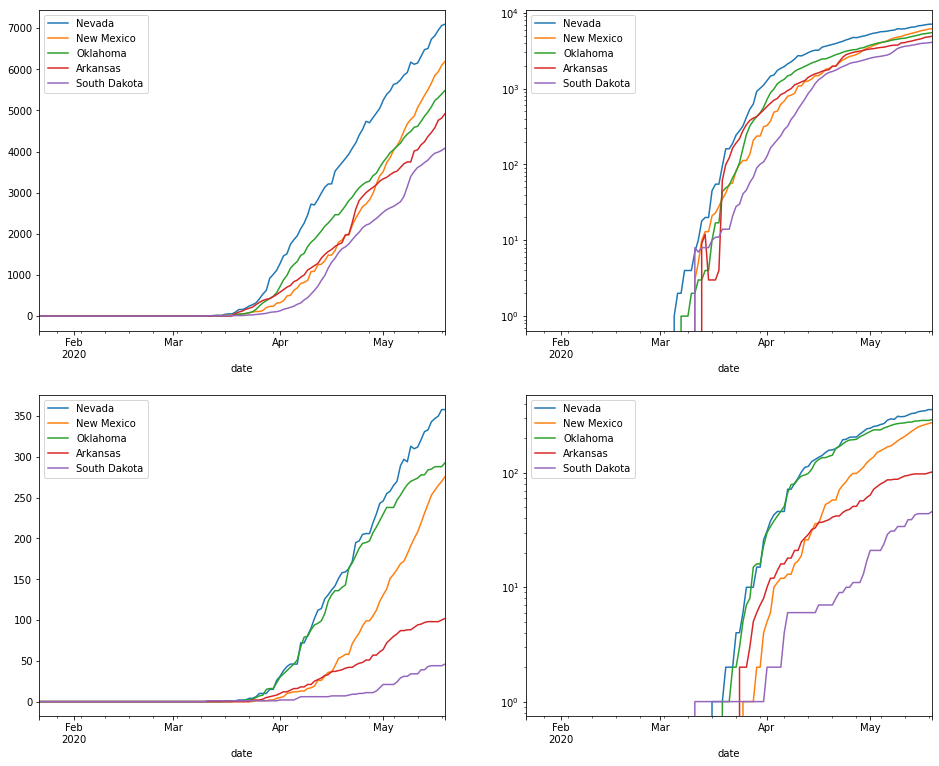

In [28]:
plot_state(cases, deaths, state=list(cases_summary.index[35:40]))

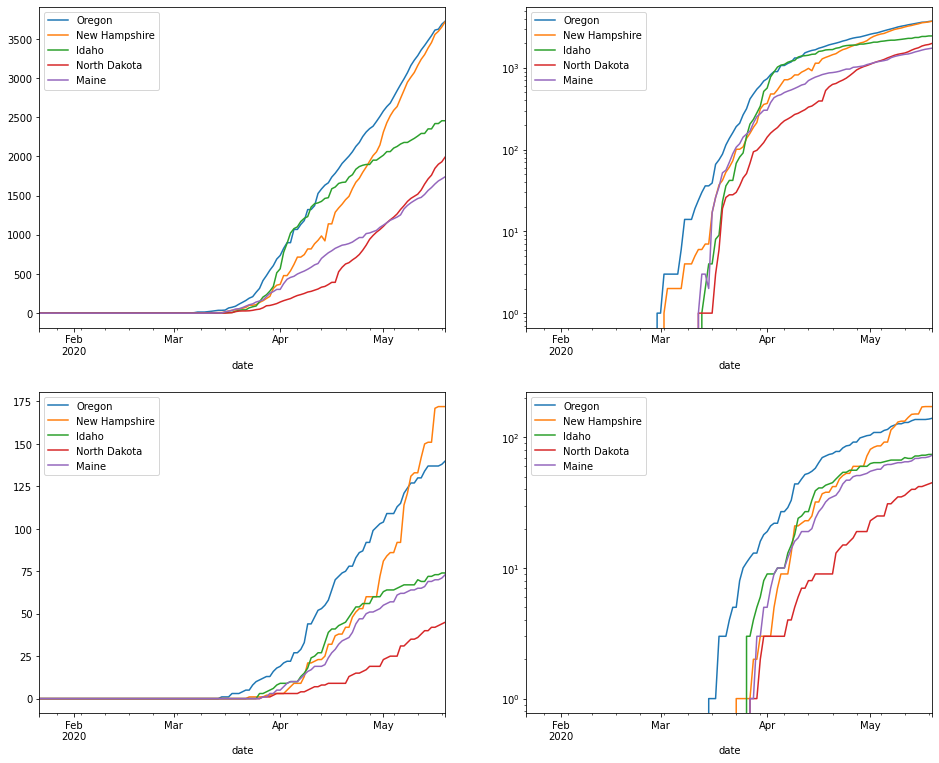

In [29]:
plot_state(cases, deaths, state=list(cases_summary.index[40:45]))

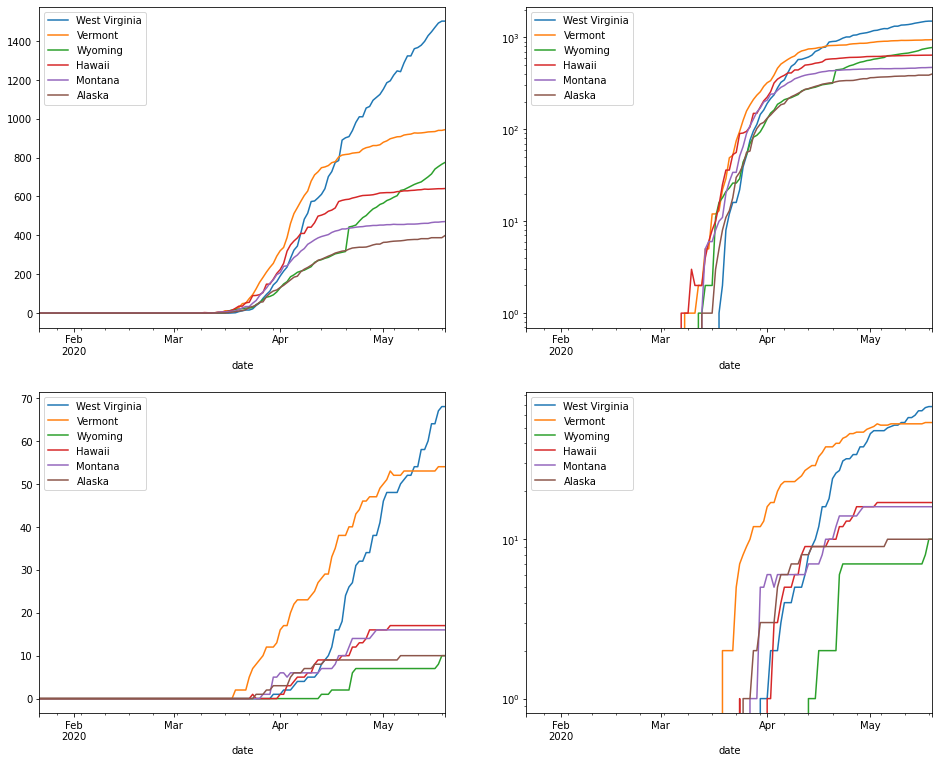

In [30]:
plot_state(cases, deaths, state=list(cases_summary.index[45:]))

In [31]:
def plot_daily(cases, deaths, state):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
    # Cases
    # df1 = cases.loc[cases[state] >0, state].to_frame()
    df1 = cases[state].to_frame()
    df1.columns = ["cases"]
    df1["daily cases"] = df1["cases"].diff()
    df1.loc[df1["daily cases"].isna(), "daily cases"] = 0
    # data["daily_smooth"] = signal.savgol_filter(data["daily cases"], 11, 3)
    df1["daily_smooth_2"] = signal.savgol_filter(df1["cases"], 11, 3, deriv=1)
    # data.reset_index("day", drop=True, inplace=True)
    df1.reset_index("day_of_year", drop=True, inplace=True)
    df1["cases"].plot(ax=ax1, color="r", title=f"Cases in {state}", legend=True, label="Cumulative")
    df1["daily cases"].plot(ax=ax1, secondary_y=True, style="co--", legend=True, label="Daily")  
    # data["daily_smooth"].plot(secondary_y=True, color="b", rot=0, legend=True, label="Daily 2")  
    df1["daily_smooth_2"].plot(ax=ax1, secondary_y=True, color="b", legend=True, label="Daily 2")
    # Deaths
    # df2 = deaths.loc[deaths[state] >0, state].to_frame()
    df2 = deaths[state].to_frame()
    df2.columns = ["deaths"]
    df2["daily deaths"] = df2["deaths"].diff()
    df2.loc[df2["daily deaths"].isna(), "daily deaths"] = 0
    # data["daily_smooth"] = signal.savgol_filter(data["daily cases"], 11, 3)
    df2["daily_smooth_2"] = signal.savgol_filter(df2["deaths"], 11, 3, deriv=1)
    # data.reset_index("day", drop=True, inplace=True)
    df2.reset_index("day_of_year", drop=True, inplace=True)
    df2["deaths"].plot(ax=ax2, color="r", title=f"Deaths in {state}", legend=True, label="Cumulative")
    df2["daily deaths"].plot(ax=ax2, secondary_y=True, style="co--", legend=True, label="Daily")  
    # data["daily_smooth"].plot(secondary_y=True, color="b", rot=0, legend=True, label="Daily 2")  
    df2["daily_smooth_2"].plot(ax=ax2, secondary_y=True, color="b", legend=True, label="Daily 2")  

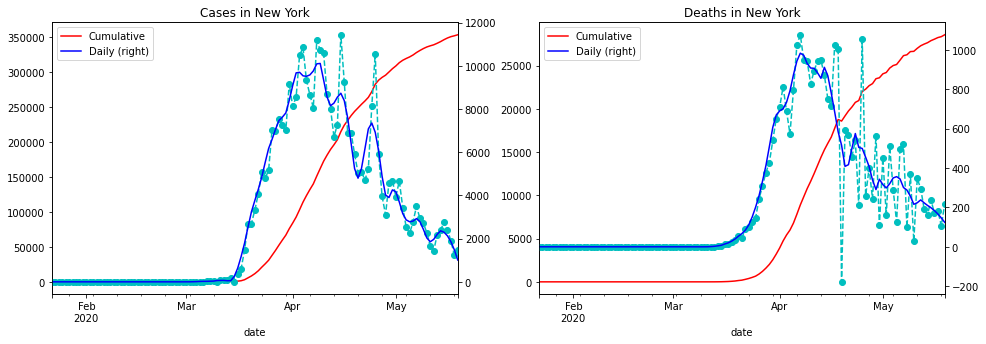

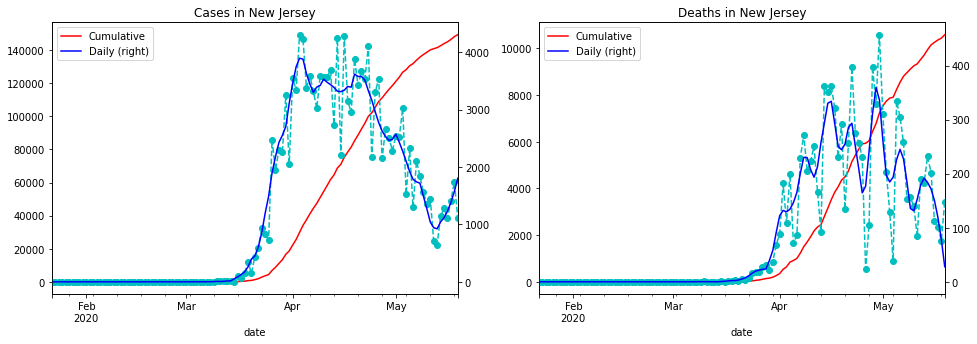

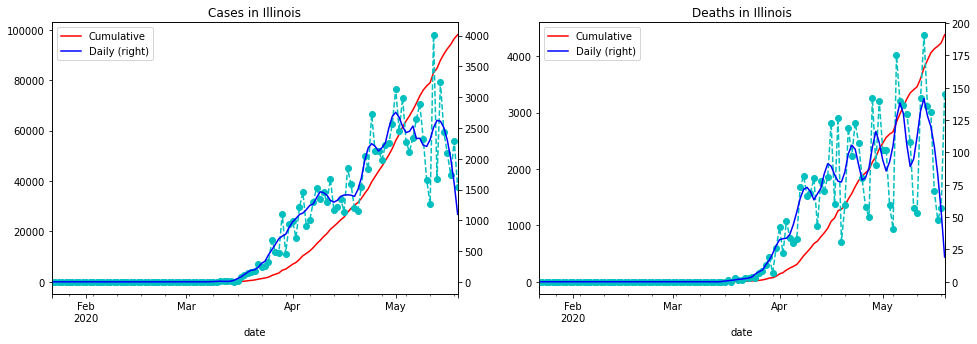

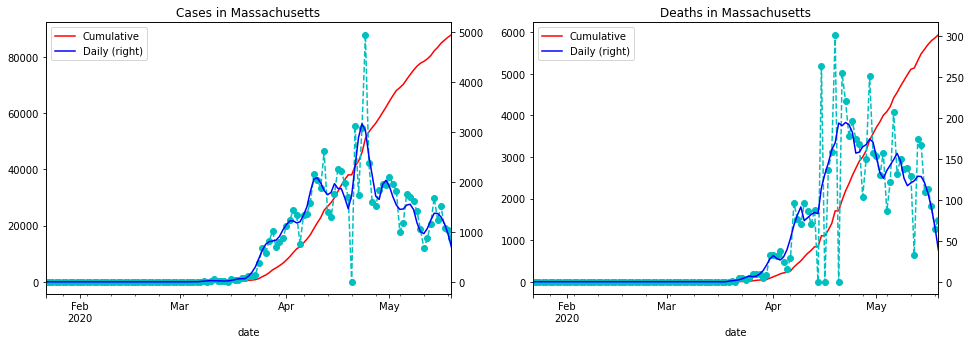

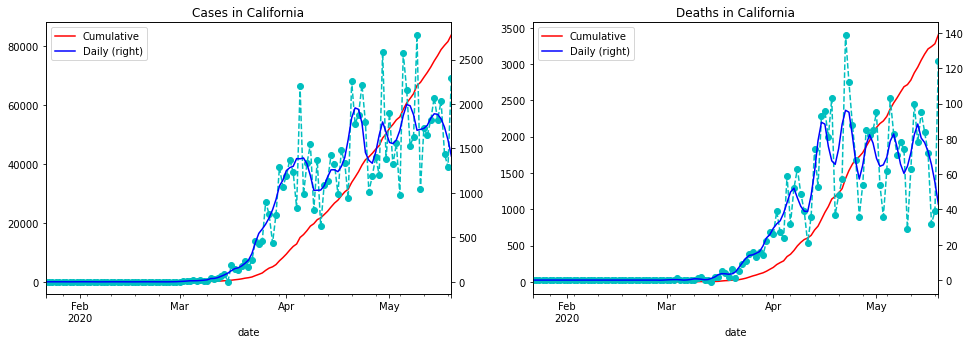

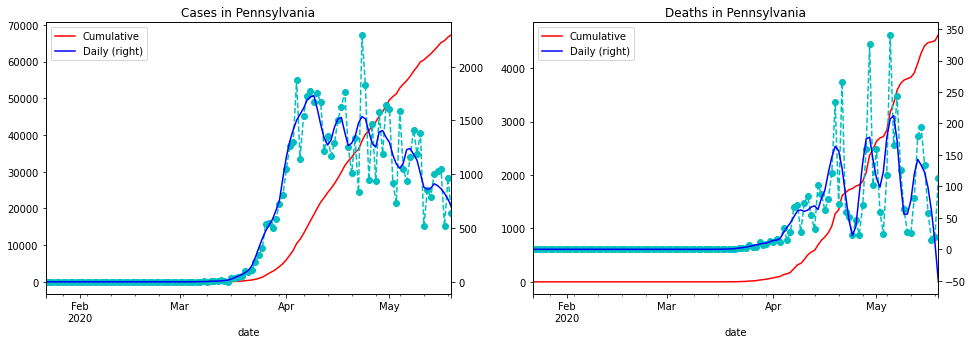

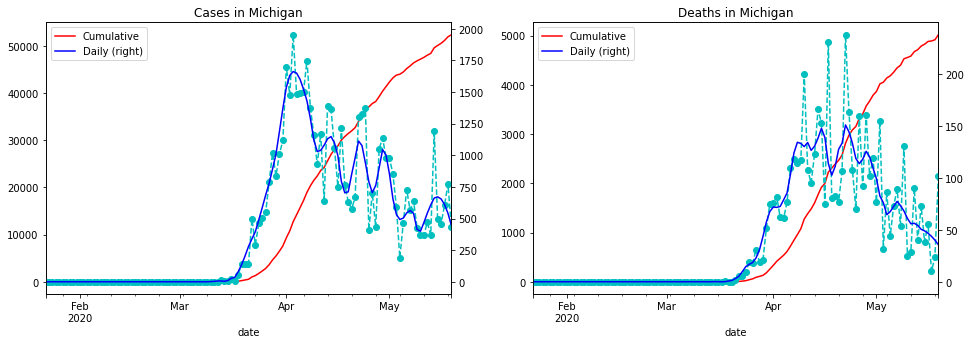

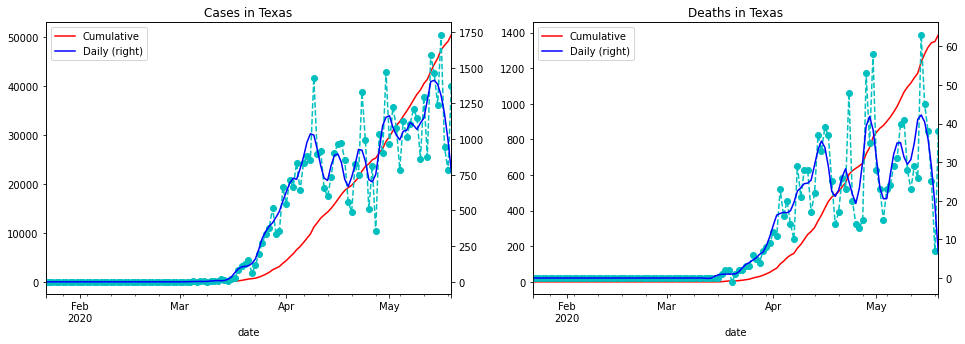

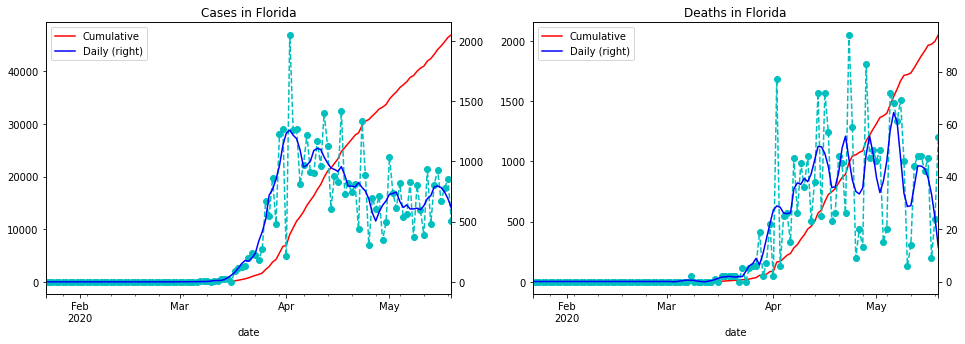

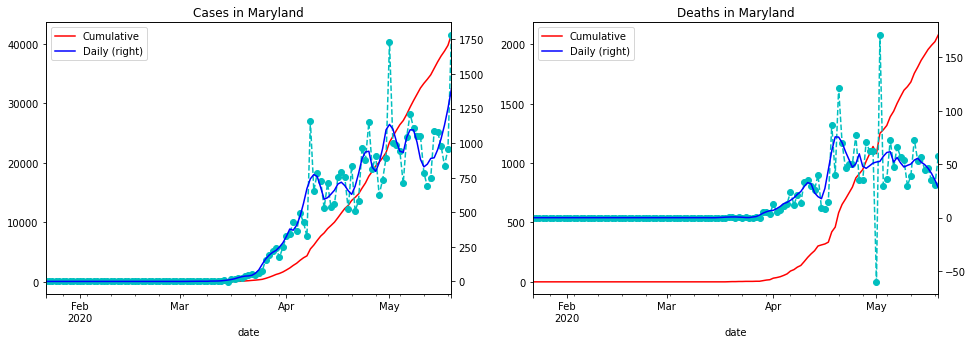

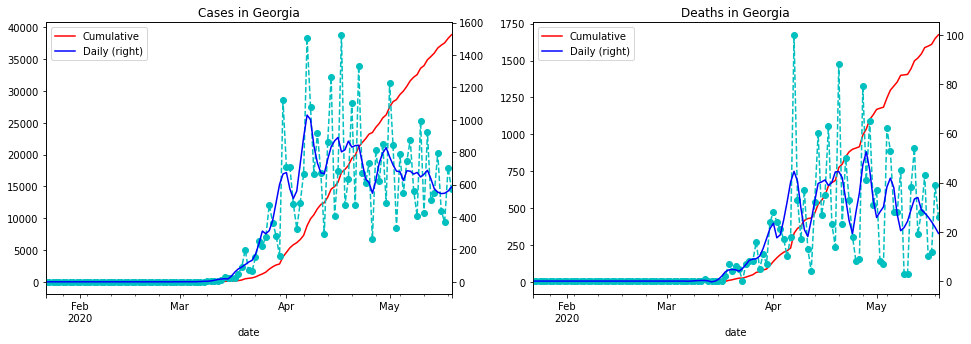

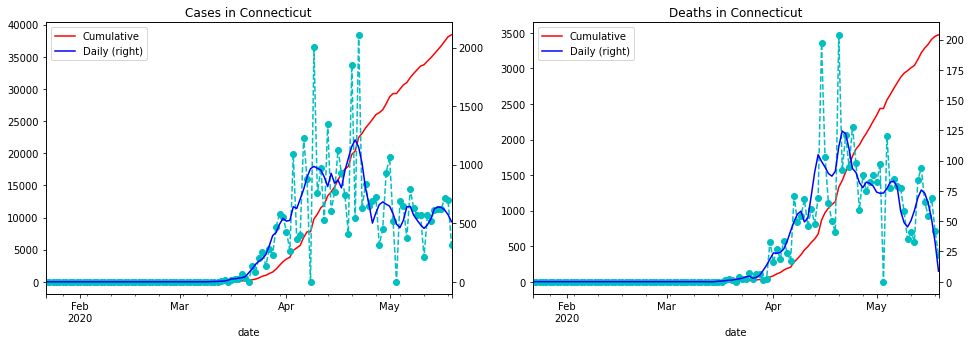

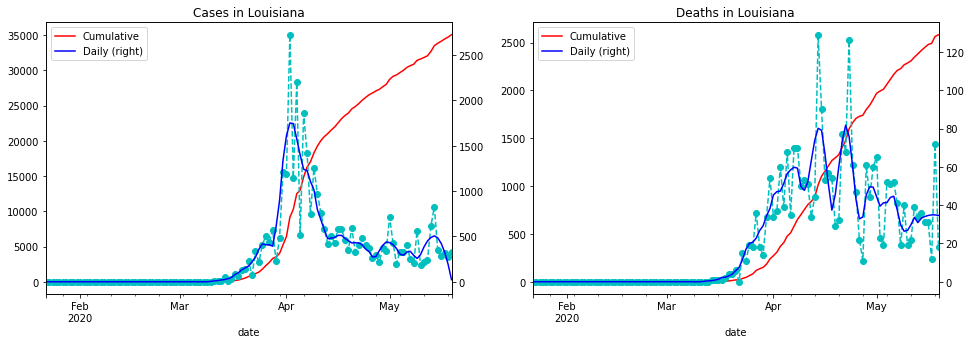

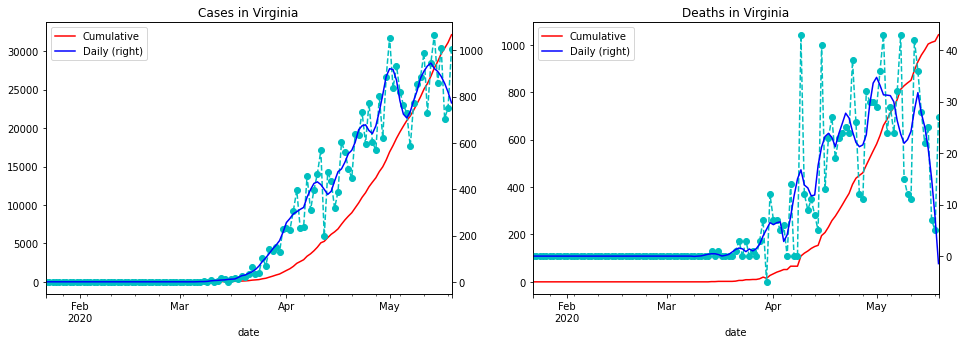

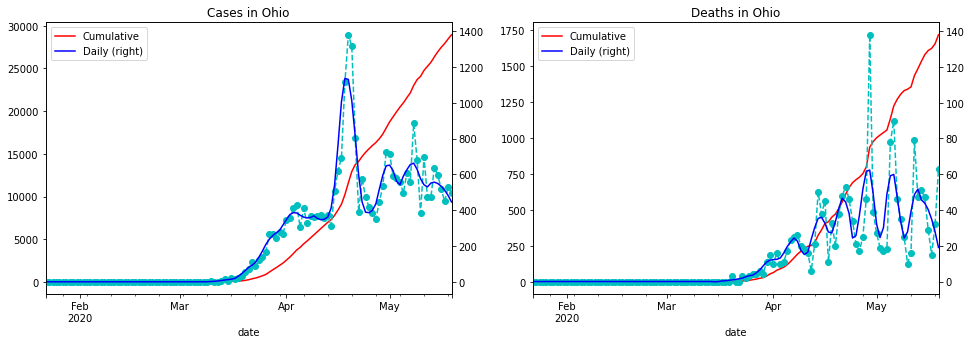

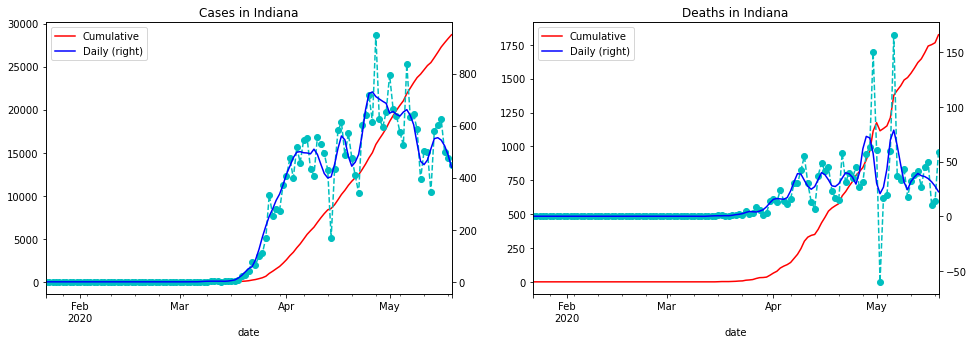

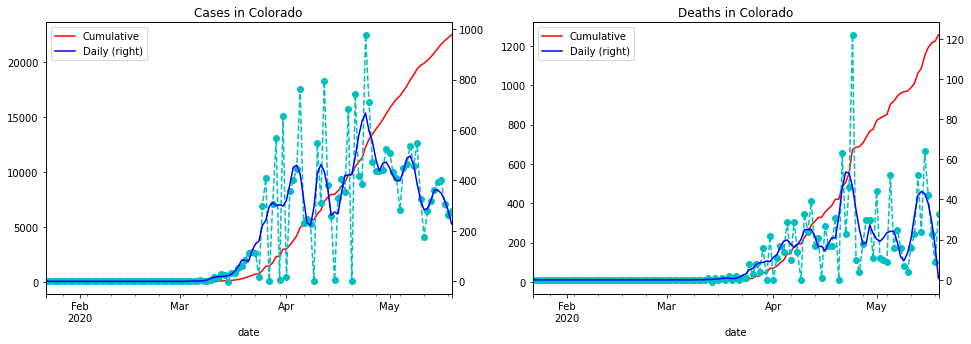

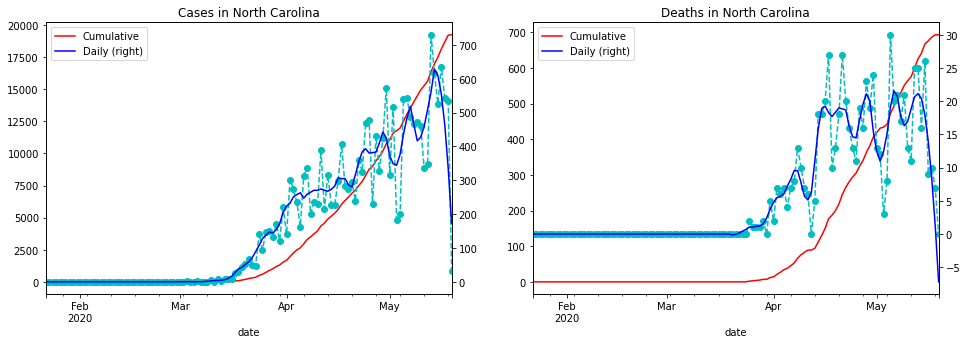

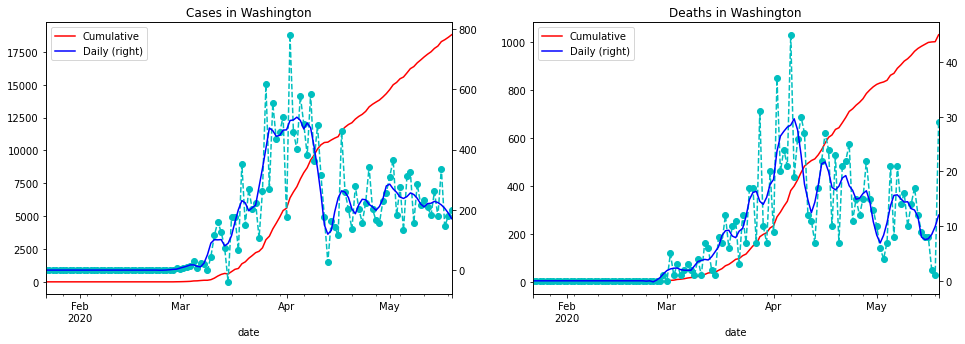

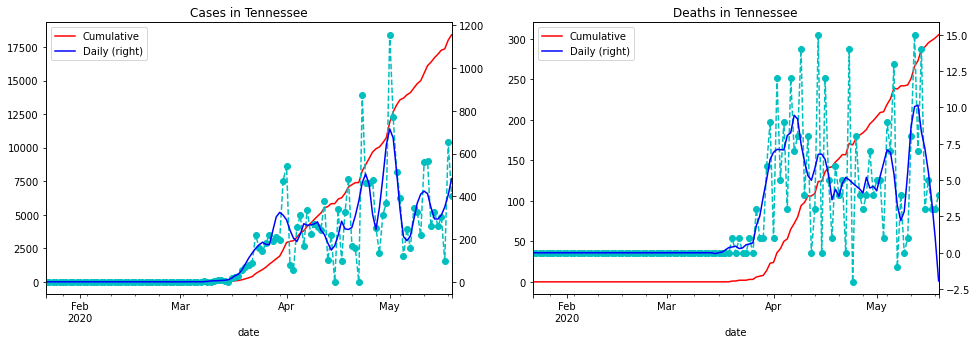

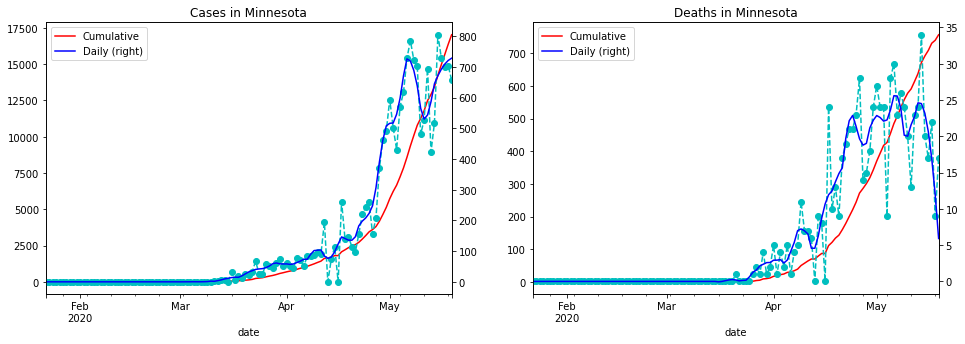

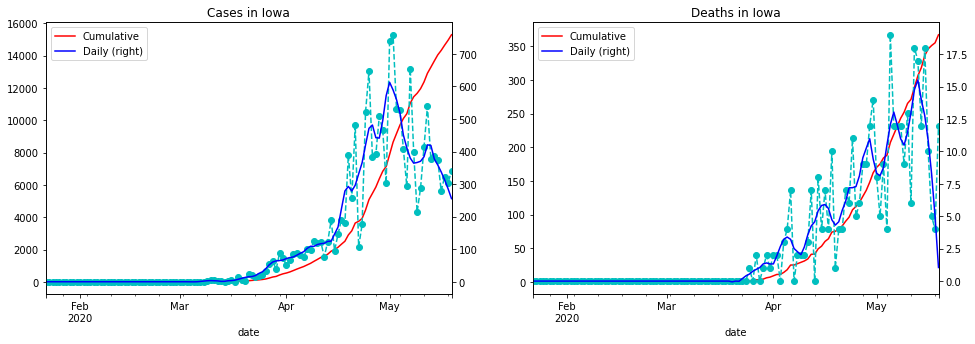

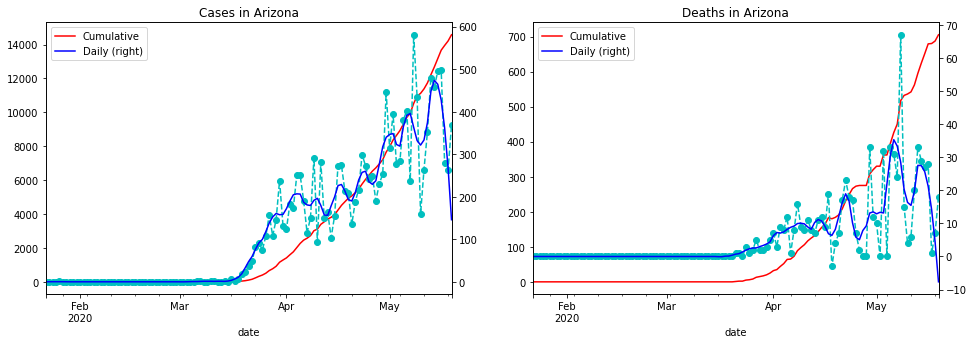

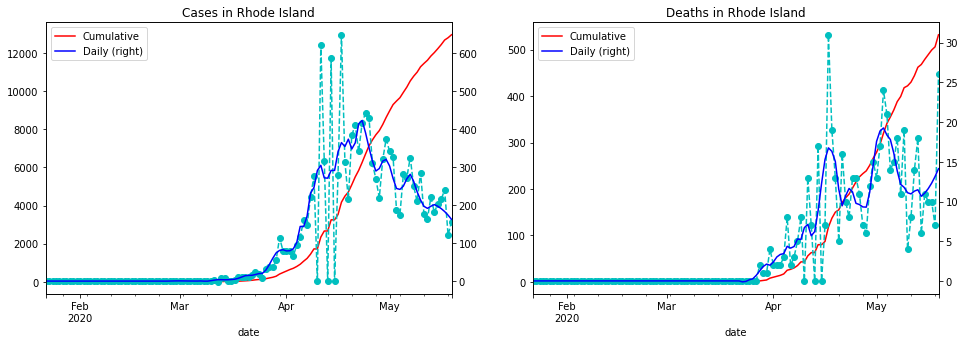

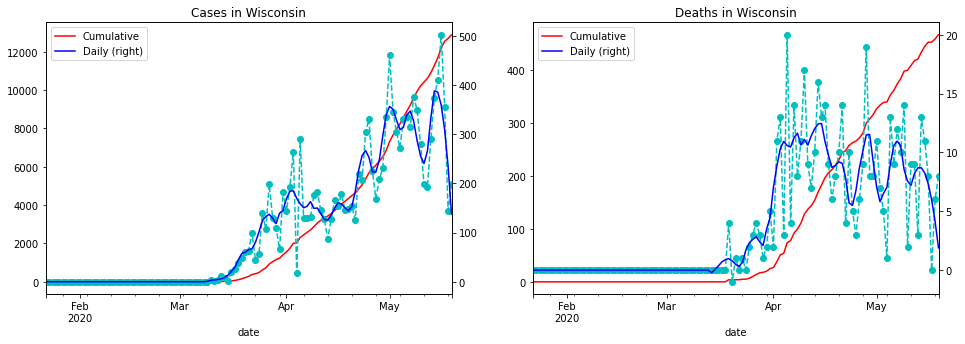

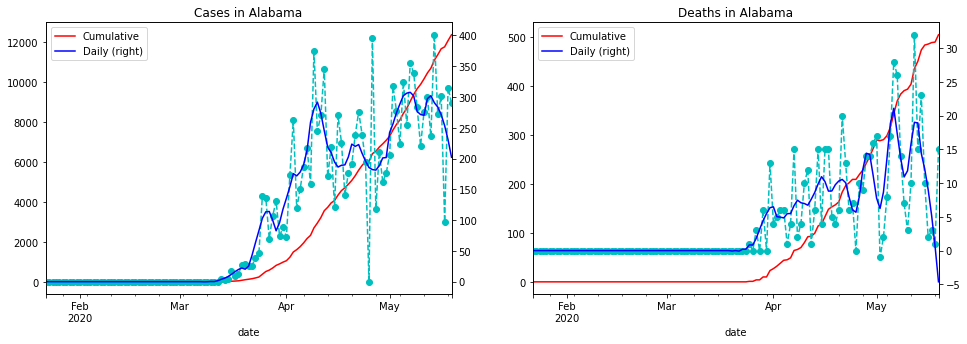

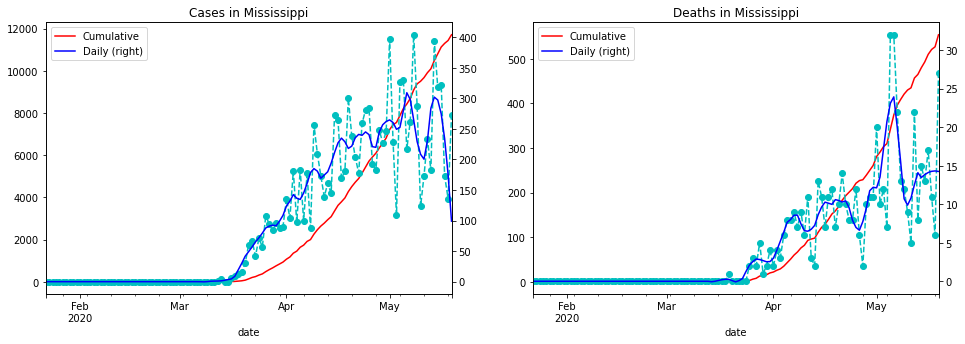

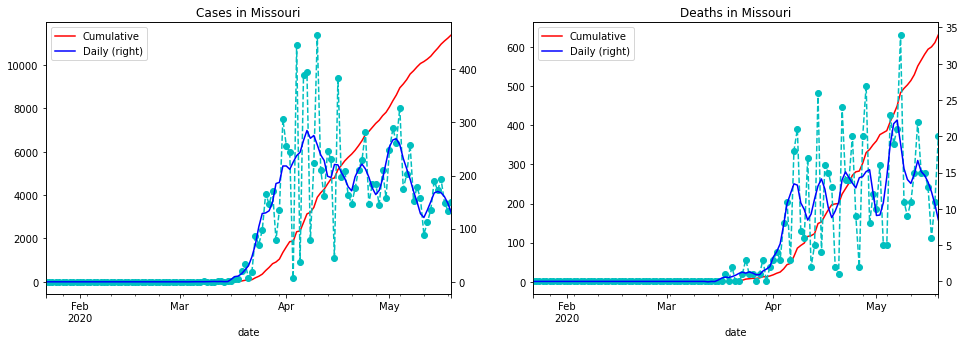

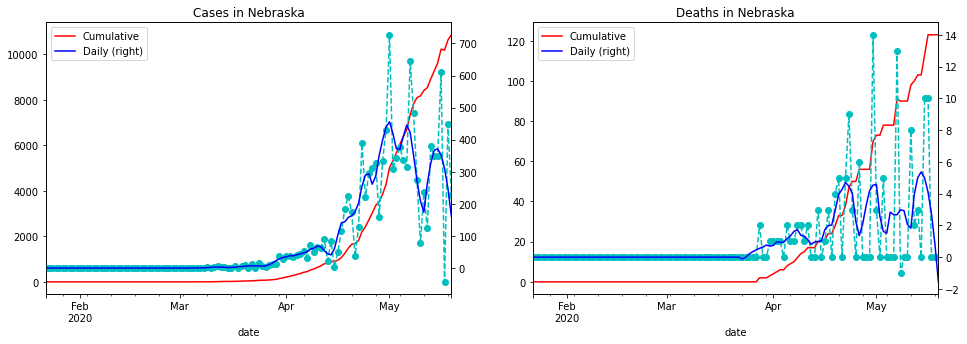

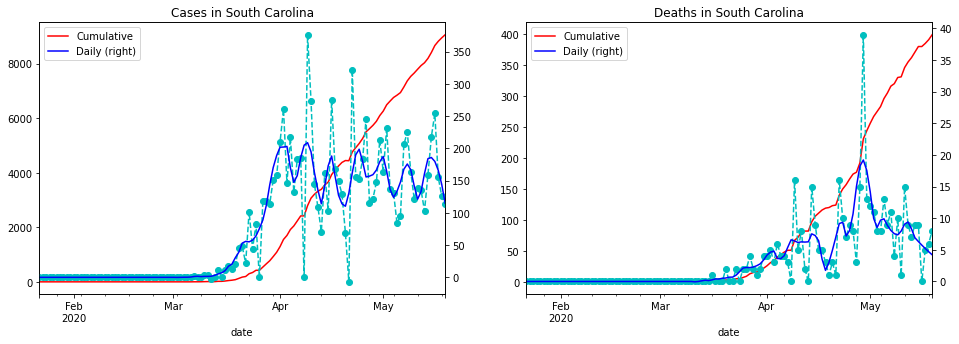

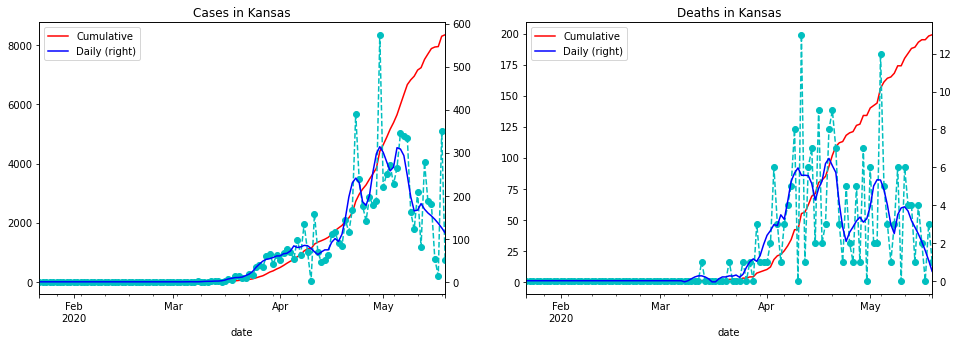

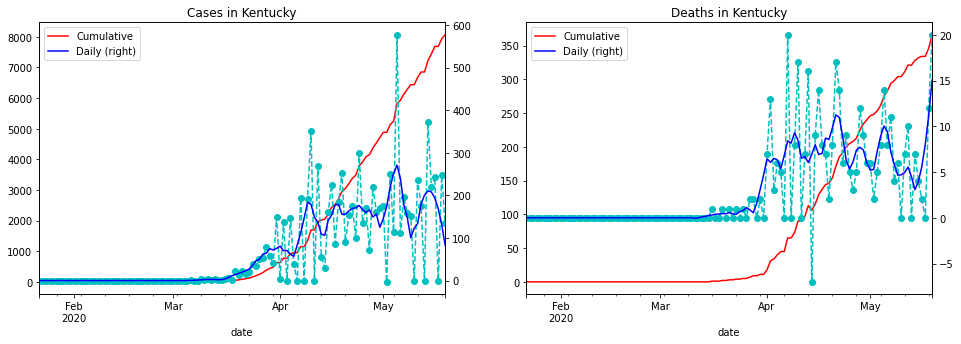

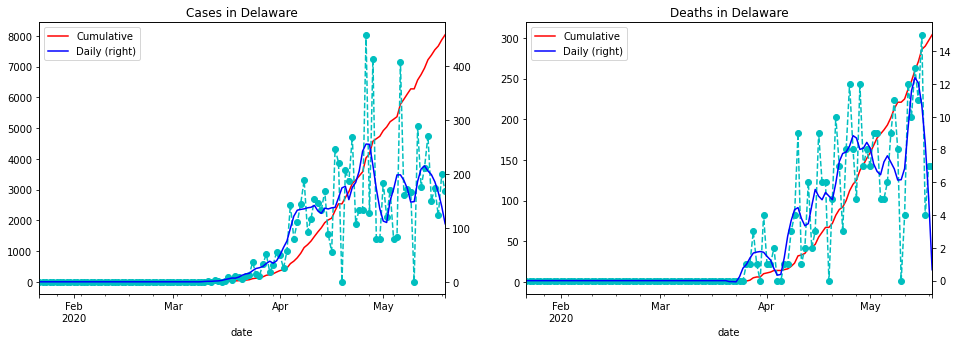

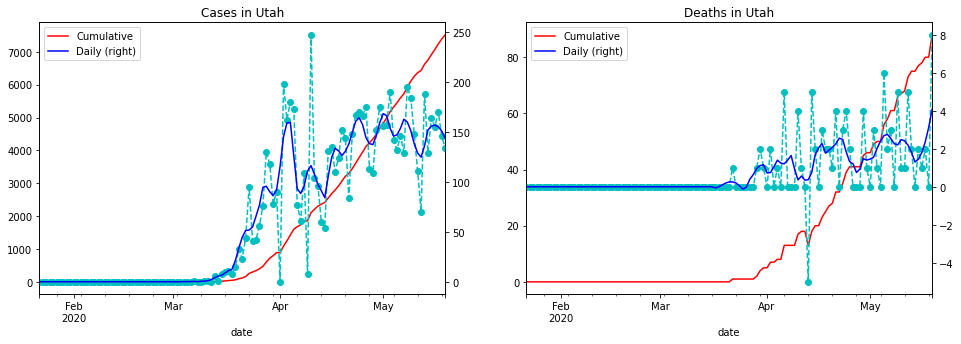

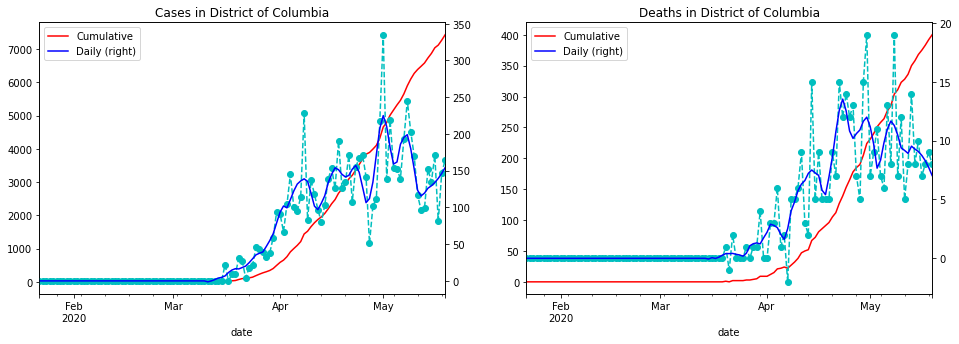

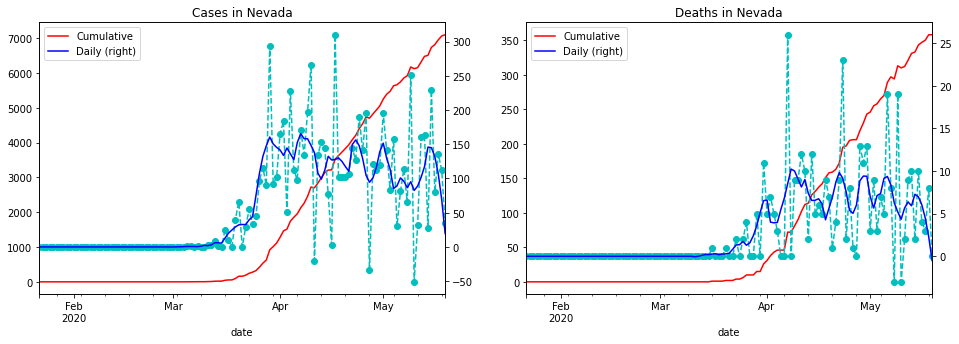

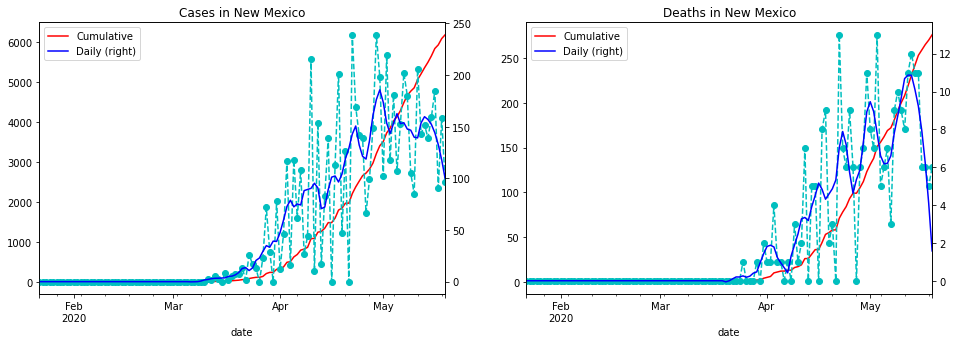

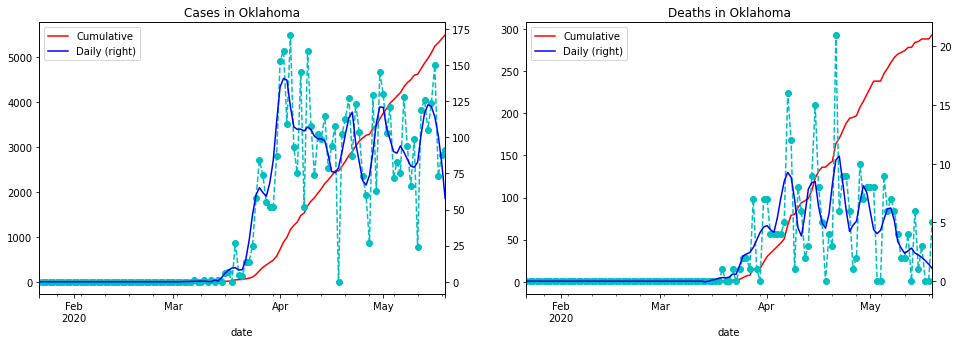

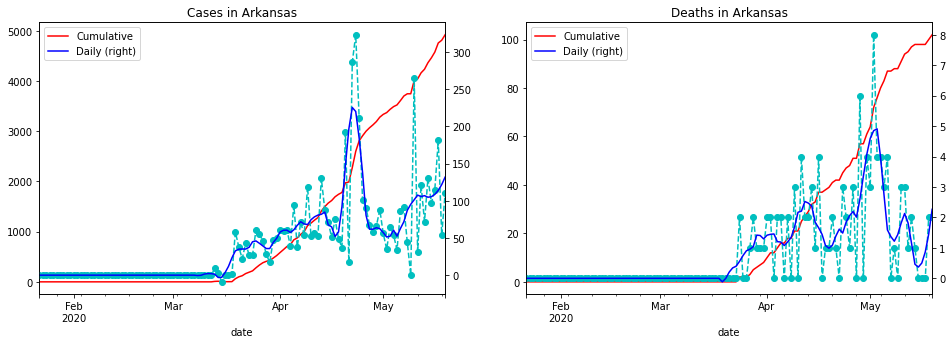

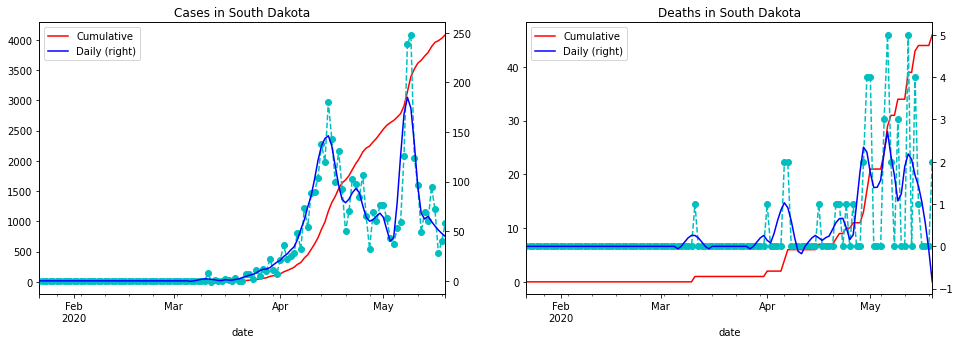

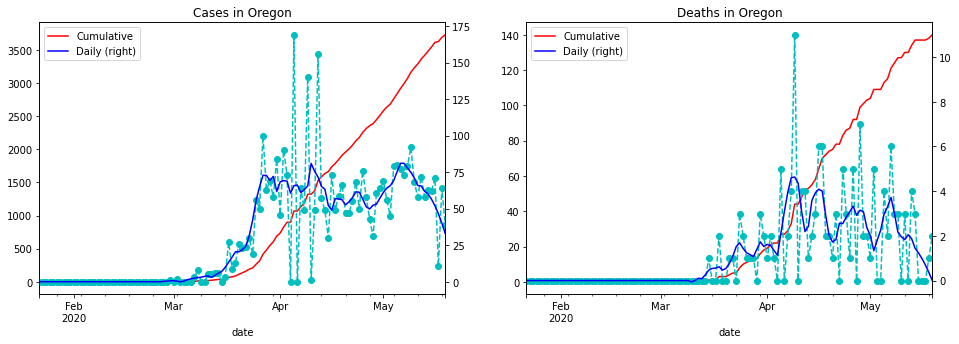

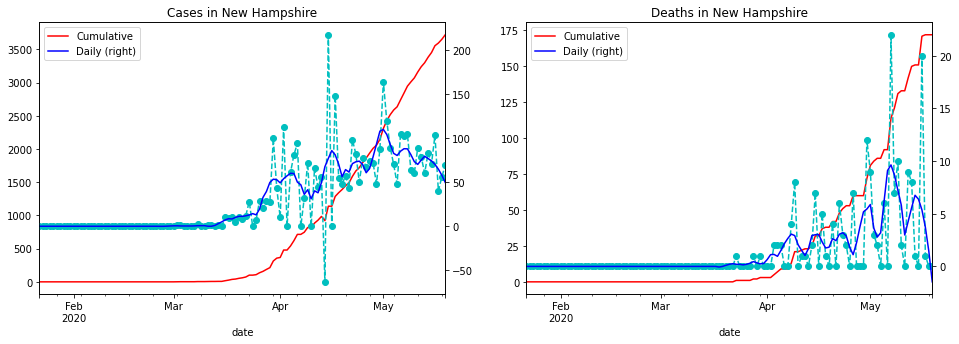

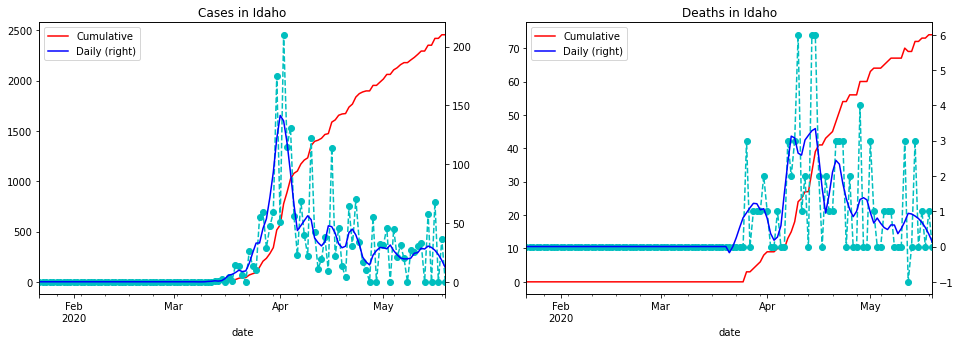

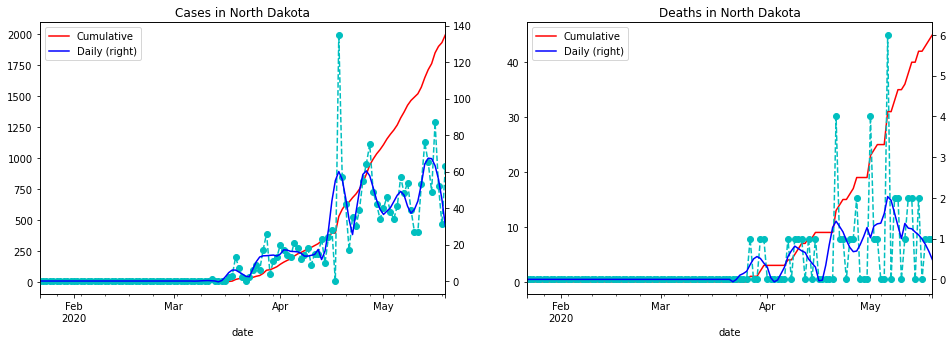

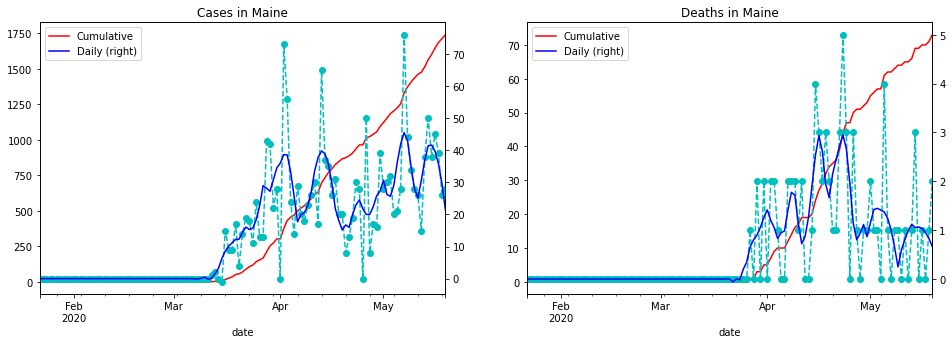

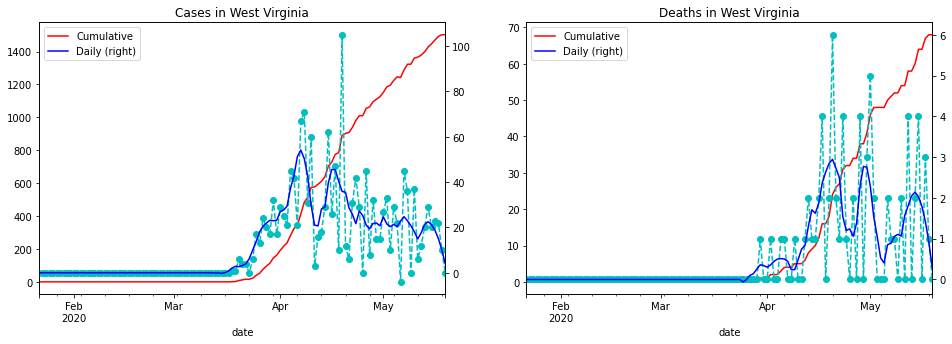

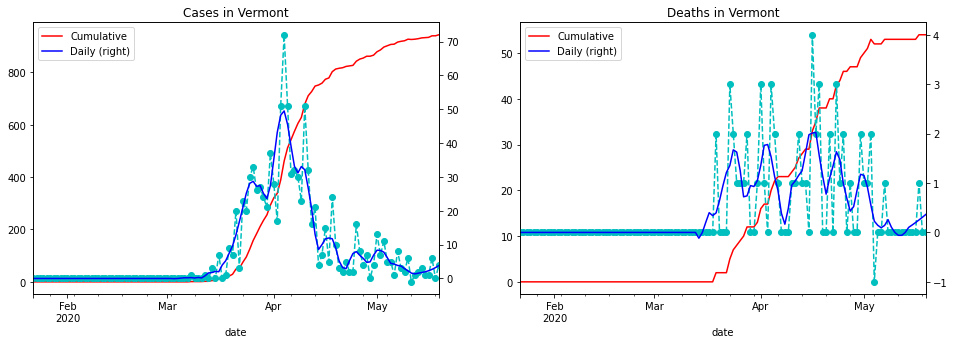

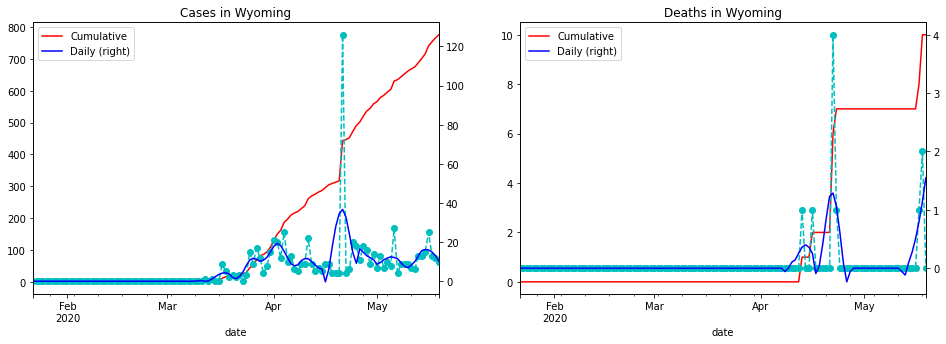

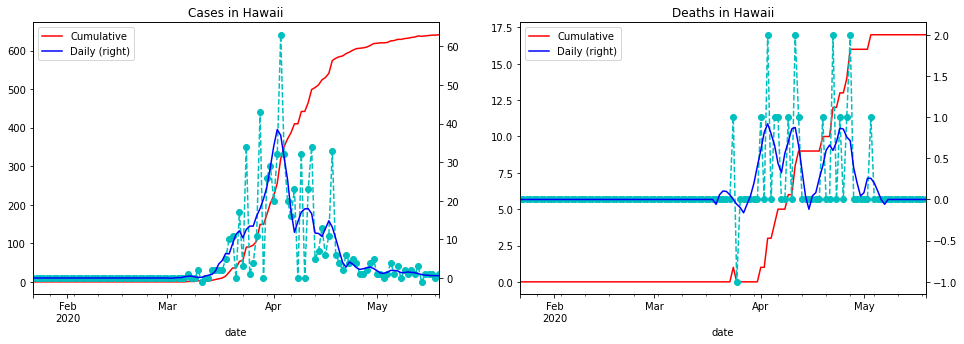

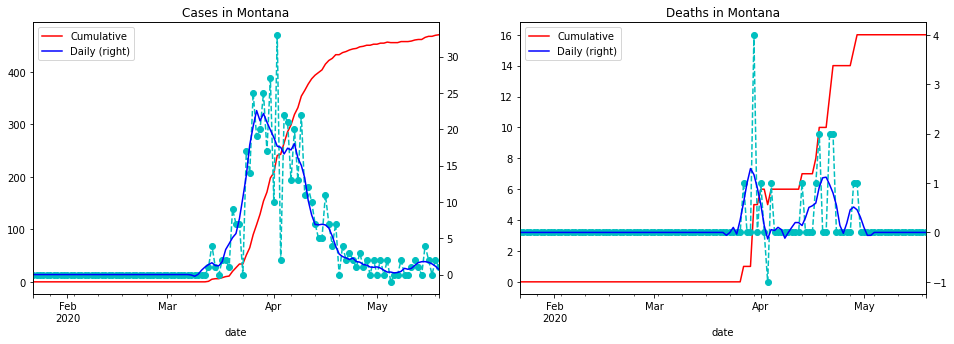

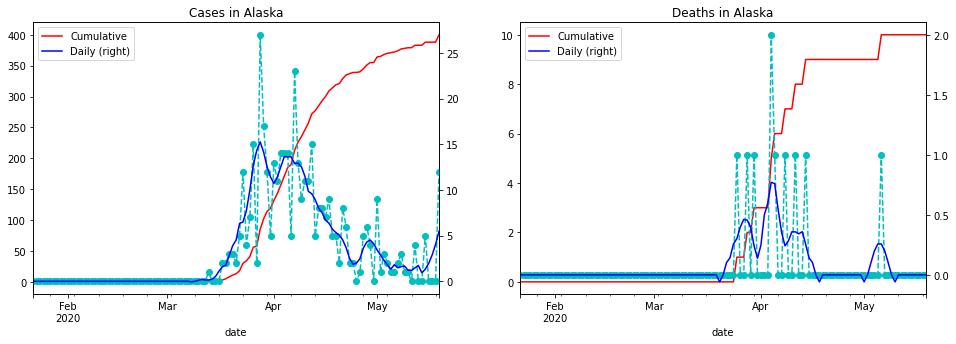

In [33]:
for c in cases_summary.index:
    plot_daily(cases, deaths, c)
    plt.show()

In [34]:
deaths_summary.head()

Alabama        504
Alaska          10
Arizona        705
Arkansas       102
California    3403
dtype: int64

In [35]:
number_of_state = 10

In [36]:
by_state = pd.concat([cases_summary, deaths_summary], axis=1)

In [37]:
by_state.columns = ["Cases", "Deaths"]

In [38]:
by_state.sort_values(by="Cases", ascending=False, inplace=True)

In [39]:
by_state = pd.concat([
    by_state.iloc[:number_of_state],
    pd.DataFrame([by_state.iloc[number_of_state:].sum(), ])
]
)

In [40]:
by_state.rename(index={0: 'others'}, inplace=True)

In [41]:
by_state

Cases  Deaths
New York       352845   28558
New Jersey     149356   10587
Illinois        98030    4379
Massachusetts   87925    5938
California      83752    3403
Pennsylvania    67311    4628
Michigan        52350    5017
Texas           50552    1388
Florida         46944    2052
Maryland        41546    2081
others         494756   23750

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f6734fb5c90>,
      dtype=object)

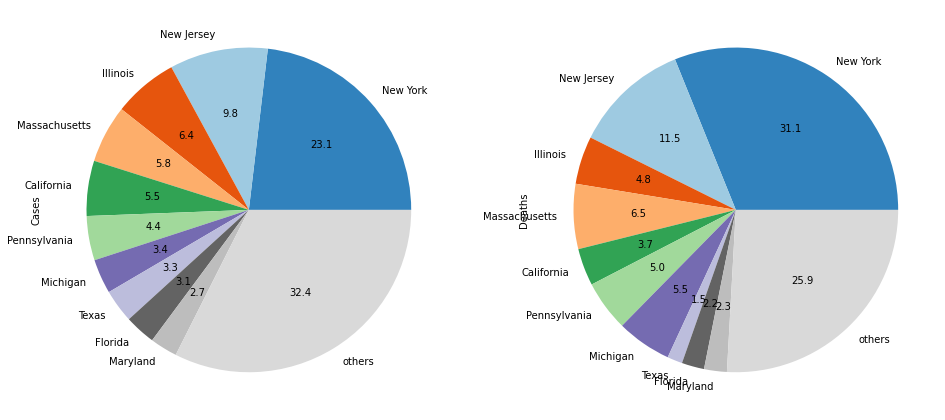

In [43]:
by_state.plot.pie(subplots=True, figsize=(16, 9), cmap=plt.cm.get_cmap('tab20c'), legend=False, autopct='%.1f')